In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
import glikonal_grrp as grrp
import pyvista as pv
import matplotlib
from matplotlib.colors import LinearSegmentedColormap



In [2]:
@jit(nopython=True)
def glide_ratio(a,wind):
    k=np.linalg.norm(wind) #ratio between the wind speed and the airspeed of the aircraft. gamma should be (1+k)/(1-k)
    return np.sqrt(1-k**2+k**2*np.sum(a*wind)**2)+k*np.sum(a*wind)
    

## Anisotropic Optimal Control
We implement the algorithm from section 6 of the Sethian paper.
We triangulate the square mesh by including as neighbors nodes on the increasing diagonal, i.e. we connect i,j to i+1,j+1.
The optimal control problem we want to solve is 

$\min_{a\in\mathcal A}t(x)$, where $x: \mathbb R\mapsto \mathbb R^2$ is a curve starting at $x_0$ and obeying the ODE $\frac{dx}{dt}=a f(x,a)$. $f(x,a)$ is the velocity of the curve at potition x, and then $dx/dt$ points in direction $a$.
$t(x)$ is the minimal time it takes fr the curve to reach point $x$.



## Point source test with constant wind and no terrain

In [3]:
H=101 
W=101
Z=20 #number of vertical points in the wind vector field

hy=1 #grid spacing in the y direction
hx=1 #grid spacing in the x direction
hz=200 #vertical spacing of the wind vector field

#define the wind vector field
wind_angles=-np.ones([H,W,Z])*2*np.pi/3 #np.random.uniform(0,2*np.pi,size=[H,W])#with respect to the y axis, positive towards east (clockwise)
wind_field=np.zeros([H,W,Z,2])
wind_strength=0.6*np.ones([H,W,Z])
wind_field[...,0]=wind_strength*np.cos(wind_angles)
wind_field[...,1]=wind_strength*np.sin(wind_angles)

Gamma=(1+np.max(wind_strength))/(1-np.max(wind_strength))#ratio between the largest and lowest value glide_ratio can take.
#ratio between the largest and lowest value glide_ratio can take.

elevation=0*np.ones([H,W]) #elevation profile

#initial position and altitude of aircraft
init_pos=(H//2,W//2) #source position
init_altitude=100

In [4]:
#use the solver to obtain the approximate solution for the gliding range
radius=2.9 
wind=wind_field[0,0,np.round(init_altitude/hz).astype(int)]
init_nodes,init_values,init_chars=grrp.point_source_HJB_uniform_solver(init_pos,init_altitude,radius, H,W,hy,hx,velocity_func=lambda a: glide_ratio(a,wind))
grid,grid_chars=grrp.OUM_GRRP(velocity_func=glide_ratio,Gamma=Gamma,elevation=elevation,init_nodes=init_nodes,init_altitudes=init_values,init_chars=init_chars, hy=hy,hx=hx,hz=hz,H=H,W=W,wind_field=wind_field)

In [5]:
#finding the true solution
radius=np.sqrt((H*hy)**2+(hx*W)**2)
init_nodes,init_values,init_chars=grrp.point_source_HJB_uniform_solver(init_pos,init_altitude,radius, H,W,hy,hx,velocity_func=lambda a: glide_ratio(a,wind))
true_grid=np.inf*np.ones([H,W])
true_grid_chars=np.zeros([H,W,2])
for i,pos in enumerate(init_nodes):
    true_grid[pos]=init_values[i]
    true_grid_chars[pos]=init_chars[i]

/Users/piccioli/opt/anaconda3/envs/torch/lib/python3.8/site-packages/mpl_toolkits/mplot3d/axes3d.py:1754: RuntimeWarning: invalid value encountered in subtract
  v2[poly_i, :] = ps[i2, :] - ps[i3, :]
/Users/piccioli/opt/anaconda3/envs/torch/lib/python3.8/site-packages/mpl_toolkits/mplot3d/axes3d.py:1753: RuntimeWarning: invalid value encountered in subtract
  v1[poly_i, :] = ps[i1, :] - ps[i2, :]
/Users/piccioli/opt/anaconda3/envs/torch/lib/python3.8/site-packages/numpy/core/numeric.py:1670: RuntimeWarning: invalid value encountered in subtract
  cp1 -= tmp
/Users/piccioli/opt/anaconda3/envs/torch/lib/python3.8/site-packages/mpl_toolkits/mplot3d/proj3d.py:113: RuntimeWarning: invalid value encountered in divide
  txs, tys, tzs = vecw[0]/w, vecw[1]/w, vecw[2]/w


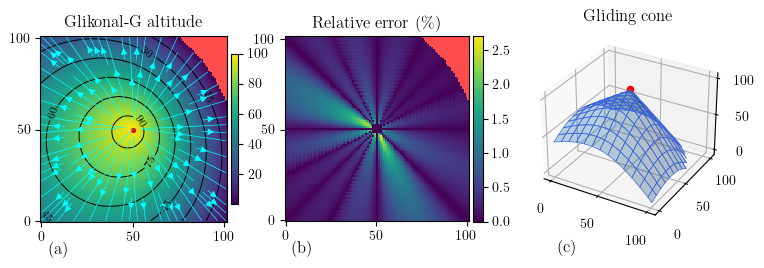

In [6]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 10}

matplotlib.rc('font', **font)
plt.rcParams.update({
    "text.usetex": True})

fig,axes=plt.subplots(1,3,figsize=(7.4,3.4))
fig.tight_layout(pad=0.5)


ax=axes[0]
X,Y=np.meshgrid(np.linspace(0,hx*W,W),np.linspace(0,hy*H,H))

im1=ax.pcolormesh(X,Y,grid,cmap='viridis',shading='nearest')
CS=ax.contour(X,Y,grid,colors='k',linewidths=0.7)
ax.clabel(CS, fontsize=8, inline=True)
ax.streamplot(X,Y,grid_chars[:,:,1],grid_chars[:,:,0],density=0.8,color='aqua',linewidth=0.5)
ax.set_aspect('equal')
ax.set_title('Glikonal-G altitude')
ax.scatter(init_pos[1],init_pos[0],color="red",label="glider",s=8)
fig.colorbar(im1,ax=ax,fraction=0.038, pad=0.02)

ax.set_xticks([0,50,100])
ax.set_yticks([0,50,100])
ax.text(0.1, -0.15, "(a)", ha='center', va='center', transform=ax.transAxes, fontsize=12)

grid2=np.copy(grid)
grid2[grid2==-np.inf]=0
grid2[grid2>0]=np.inf
grid2[0,0]=1


colors = [(1-c,0,0,1) for c in np.linspace(0,1,100)]# Create the colormap
cmap_name = 'red_to_black'
n_bins = 100  # Number of bins (discrete color levels)
cmap_red = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
pc2=ax.pcolormesh(X,Y,grid2,cmap=cmap_red,shading='nearest',alpha=0.7)

ax=axes[1]
grid_lost_altitude=init_altitude-grid
true_grid_lost_altitude=init_altitude-true_grid
rel_error=np.abs(grid_lost_altitude-true_grid_lost_altitude)/(true_grid_lost_altitude+1e-10)

im=ax.pcolormesh(X,Y,100*rel_error,cmap='viridis',shading='nearest')
#fig.colorbar(im,ax=ax)
#CS=ax.contour(X,Y,rel_error,colors='k')
#ax.clabel(CS, fontsize=9, inline=True)
ax.set_aspect('equal')
ax.set_title('Relative error (\%)')
ax.set_xticks([])
ax.set_yticks([])
fig.colorbar(im,ax=ax,fraction=0.047, pad=0.02)
ax.set_xticks([0,50,100])
ax.set_yticks([0,50,100])
ax.text(0.1, -0.15, "(b)", ha='center', va='center', transform=ax.transAxes, fontsize=12)
pc2=ax.pcolormesh(X,Y,grid2,cmap=cmap_red,shading='nearest',alpha=0.7)

axes[2].remove()
#3D surface representing the gliding cone.
ax = fig.add_subplot(1,3,3,projection='3d')
ax.scatter(init_pos[1],init_pos[0],init_altitude,color="red",label="glider")

ax.plot_surface(X,Y, grid, edgecolor='royalblue', lw=0.5, rstride=8, cstride=8,
                alpha=0.3,label="minimal altitude")
plt.title("Gliding cone")
ax.set_xticks([0,50,100])
ax.set_yticks([0,50,100])
ax.text(x=0.1, y=-0.15, z=-118, s="(c)",fontsize=12)

#ax.set_zticks([])


plt.savefig("pics/glikonal_grrp_flat.pdf", bbox_inches='tight', dpi=600)

## Example with single obstacle in the flight path

In [7]:
H=101 
W=101
Z=20 #number of vertical points in the wind vector field

hy=1 #grid spacing in the y direction
hx=1 #grid spacing in the x direction
hz=10 #vertical spacing of the wind vector field

#define the wind vector field
wind_angles=np.ones([H,W,Z])*0 #np.random.uniform(0,2*np.pi,size=[H,W])#with respect to the y axis, positive towards east (clockwise)
for x in range(W):
    for y in range(H):
        wind_angles[y,x]=(x+y)/50
wind_field=np.zeros([H,W,Z,2])
wind_strength=np.ones([H,W,Z])
max_wind=0.6
max_alt=Z*hz
for z in range(Z):
    alt=hz*z
    wind_strength[...,z]=max_wind*(0.8+0.2*alt/max_alt)*np.ones([H,W])
wind_field[...,0]=wind_strength*np.cos(wind_angles) #wind field in the y direction
wind_field[...,1]=wind_strength*np.sin(wind_angles) #wind field in the x direction

Gamma=(1+np.max(wind_strength))/(1-np.max(wind_strength))#ratio between the largest and lowest value glide_ratio can take.


center=(H//2,W//3)
yy,xx=np.meshgrid(np.arange(0,H,hy,dtype=np.intc),np.arange(0,W,hx,dtype=np.intc))
elevation=114*np.exp(-((xx-center[0])**2+(yy-center[1])**2)/510) #set the elevation profile


#initial position and altitude of aircraft
init_pos=(H//2,0) #source position
init_altitude=100

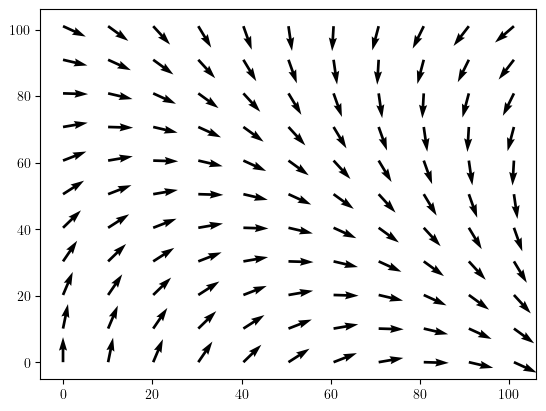

In [8]:
fig, ax = plt.subplots()
U=np.moveaxis(wind_field[...,-1,1],0,1)
V=np.moveaxis(wind_field[...,-1,0],0,1)
X,Y=np.meshgrid(np.linspace(0,hx*W,W),np.linspace(0,hy*H,H))

Nx=10
Ny=10
q = ax.quiver(X[::Nx,::Ny], Y[::Nx,::Ny], U[::Nx,::Ny], V[::Nx,::Ny])
ax.quiverkey(q, X=0.3, Y=1.1, U=10, label='Quiver key, length = 10', labelpos='E')

In [9]:
radius=2.9
init_nodes,init_values,init_chars=grrp.point_source_HJB_uniform_solver(init_pos,init_altitude,radius, H,W,hy,hx,velocity_func=lambda a: glide_ratio(a,wind))
grid,grid_chars=grrp.OUM_GRRP(velocity_func=glide_ratio,Gamma=Gamma,elevation=elevation,init_nodes=init_nodes,init_altitudes=init_values,init_chars=init_chars, hy=hy,hx=hx,hz=hz,H=H,W=W,wind_field=wind_field)
#grid=np.maximum(grid,np.zeros_like(grid))


/var/folders/n8/dxqjckvd4wl4l8rpd0n20xrw0000gp/T/ipykernel_60159/3806160875.py:7: UserWarning: The following kwargs were not used by contour: 'label'
  CS=ax.contour(X,Y,grid,colors='white',label='aircraft')


Text(0.5, 1.0, 'glide range (shaded region) plotted on top of the elevation profile')

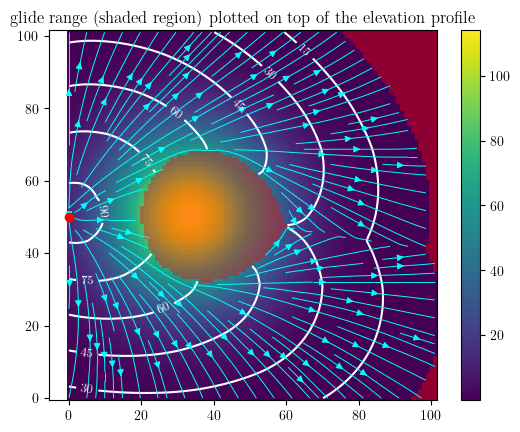

In [10]:
X,Y=np.meshgrid(np.linspace(0,hx*W,W),np.linspace(0,hy*H,H))
fig,ax=plt.subplots()

pc=ax.pcolormesh(X,Y,elevation,cmap='viridis',shading='nearest')
#pc2=ax.pcolormesh(X,Y,grid>0,cmap='binary',shading='nearest',alpha=0.1)
fig.colorbar(pc)
CS=ax.contour(X,Y,grid,colors='white',label='aircraft')
ax.streamplot(X,Y,grid_chars[:,:,1],grid_chars[:,:,0],density=1.4,color='aqua',linewidth=0.7)
ax.scatter([init_pos[1]*hx],[init_pos[0]*hy],color='r',label='aircraft',zorder=10000)

grid2=np.copy(grid)
grid2[grid2==-np.inf]=0
grid2[grid2>0]=np.inf
grid2[0,0]=1

colors = [(1-c,0,0,1) for c in np.linspace(0,1,100)]# Create the colormap
cmap_name = 'red_to_black'
n_bins = 100  # Number of bins (discrete color levels)
cmap_red = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
pc2=ax.pcolormesh(X,Y,grid2,cmap=cmap_red,shading='nearest',alpha=0.4)
ax.clabel(CS, fontsize=9, inline=True)
ax.set_aspect('equal')
ax.set_title('glide range (shaded region) plotted on top of the elevation profile')


In [11]:
grid=np.maximum(grid,np.zeros_like(grid))
grid[grid==0]=np.nan
# Create the first surface
surf1 = pv.StructuredGrid(X, Y, elevation)
surf1['elevation'] = elevation.T.flatten()

# Create the second surface
surf2 = pv.StructuredGrid(X, Y, grid)
surf2_shift = pv.StructuredGrid(X, Y, grid+0.1)# perturbing to avoid overlapping surfaces (visual artifacts)

surf2['elevation'] = grid.T.flatten()
surf2_shift['elevation'] = (grid).T.flatten()



point=[hx*init_pos[1],hy*init_pos[0],init_altitude]
point_cloud = pv.PolyData(point)
contours_alt = surf2_shift.contour()

# Plot the surfaces
plotter = pv.Plotter()
plotter.enable_anti_aliasing('msaa', multi_samples=16)

plotter.add_mesh(surf2, color='orange',cmap='viridis', opacity=0.7)
plotter.add_mesh(surf1, opacity=1,cmap='viridis',show_scalar_bar=False)
plotter.add_mesh(contours_alt, color="white", line_width=3)
plotter.add_mesh(point_cloud, color='red', point_size=10)

# Show the plot
plotter.show()
plotter.save_graphic("pics/single_peak_3d_grrp.pdf",raster=False)

/Users/piccioli/opt/anaconda3/envs/torch/lib/python3.8/site-packages/pyvista/core/utilities/points.py:52: UserWarning: Points is not a float type. This can cause issues when transforming or applying filters. Casting to ``np.float32``. Disable this by passing ``force_float=False``.
  warnings.warn(


Widget(value='<iframe src="http://localhost:59021/index.html?ui=P_0x7fd3324c8ca0_0&reconnect=auto" class="pyvi…

/var/folders/n8/dxqjckvd4wl4l8rpd0n20xrw0000gp/T/ipykernel_60159/4213123619.py:39: UserWarning: The following kwargs were not used by contour: 'label'
  CS=ax.contour(X,Y,grid,colors='white',label='aircraft',linewidths=0.7)


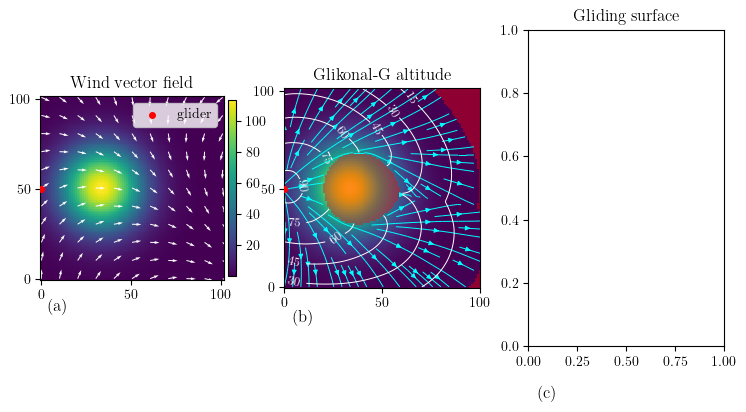

In [12]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 10}

matplotlib.rc('font', **font)
plt.rcParams.update({
    "text.usetex": True})

fig,axes=plt.subplots(1,3,figsize=(7.4,3.6))

fig.tight_layout(pad=0.6)


ax=axes[0]
U=np.moveaxis(wind_field[...,-1,1],0,1)
V=np.moveaxis(wind_field[...,-1,0],0,1)
X,Y=np.meshgrid(np.linspace(0,hx*W,W),np.linspace(0,hy*H,H))
pc=ax.pcolormesh(X,Y,elevation,cmap='viridis',shading='nearest')
fig.colorbar(pc,ax=ax,fraction=0.045, pad=0.02)
Nx=10
Ny=10

q = ax.quiver(X[::Nx,::Ny], Y[::Nx,::Ny], U[::Nx,::Ny], V[::Nx,::Ny],color='white')
#ax.quiverkey(q, X=0.3, Y=1.1, U=10,label='.')
ax.set_aspect('equal')
ax.set_xticks([0,50,100])
ax.set_yticks([0,50,100])
ax.set_title('Wind vector field')
ax.text(0.1, -0.15, "(a)", ha='center', va='center', transform=ax.transAxes, fontsize=12)
ax.scatter([init_pos[1]*hx],[init_pos[0]*hy],color='r',label='glider',zorder=10000,s=16)
ax.legend()
ax=axes[1]

X,Y=np.meshgrid(np.linspace(0,hx*W,W),np.linspace(0,hy*H,H))
pc2=ax.pcolormesh(X,Y,elevation,cmap='viridis',shading='nearest')
#pc2=ax.pcolormesh(X,Y,grid>0,cmap='binary',shading='nearest',alpha=0.1)
ax.streamplot(X,Y,grid_chars[:,:,1],grid_chars[:,:,0],density=0.84,color='aqua',linewidth=0.7,arrowsize=0.7)

CS=ax.contour(X,Y,grid,colors='white',label='aircraft',linewidths=0.7)
ax.scatter([init_pos[1]*hx],[init_pos[0]*hy],color='r',label='aircraft',zorder=10000,s=16)
#fig.colorbar(pc,ax=ax,fraction=0.044, pad=0.02)

grid2[grid2==-np.inf]=0
grid2[grid2>0]=np.inf
grid2[0,0]=1

colors = [(1-c,0,0,1) for c in np.linspace(0,1,100)]# Create the colormap
cmap_name = 'red_to_black'
n_bins = 100  # Number of bins (discrete color levels)
cmap_red = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
pc2=ax.pcolormesh(X,Y,grid2,cmap=cmap_red,shading='nearest',alpha=0.4)
ax.clabel(CS, fontsize=9, inline=True)
ax.set_aspect('equal')
ax.set_xticks([0,50,100])
ax.set_yticks([0,50,100])
ax.set_xlim([0,100])
ax.set_title('Glikonal-G altitude')
ax.text(0.1, -0.15, "(b)", ha='center', va='center', transform=ax.transAxes, fontsize=12)
ax=axes[2]
ax.set_title("Gliding surface")
ax.text(0.1, -0.15, "(c)", ha='center', va='center', transform=ax.transAxes, fontsize=12)
#axes[2].remove()
plt.savefig("pics/glikonal_grrp_single_peak.pdf", bbox_inches='tight', dpi=600)

## More realistic looking mountein range with two saddles

In [13]:
H=101 
W=101
Z=20 #number of vertical points in the wind vector field

hy=1 #grid spacing in the y direction
hx=1 #grid spacing in the x direction
hz=200 #vertical spacing of the wind vector field

#define the wind vector field
wind_angles=np.ones([H,W,Z])*0 #np.random.uniform(0,2*np.pi,size=[H,W])#with respect to the y axis, positive towards east (clockwise)
wind_field=np.zeros([H,W,Z,2])
wind_strength=0.5*np.ones([H,W,Z])

for x in range(W):
    wind_strength[:,x,:]=abs(W//2-x)/W
wind_field[...,0]=wind_strength*np.cos(wind_angles)
wind_field[...,1]=wind_strength*np.sin(wind_angles)
wind_field[:,W//2:,...]=-wind_field[:,W//2:,...]

Gamma=4#ratio between the largest and lowest value glide_ratio can take.


center=(H//2,W//2)
xx,yy=np.meshgrid(np.arange(0,W,hx,dtype=np.intc),np.arange(0,H,hy,dtype=np.intc))
peak_x=35
elevation_profile=75*np.exp(-(xx-peak_x)**2/80)
saddle_1_y=20
saddle_1_strength=40 #the higher the strength the lower the top of the saddle
saddle_2_y=80
saddle_2_strength=35
elevation=np.maximum(0,elevation_profile-saddle_1_strength*np.exp(-(yy-saddle_1_y)**2/17)-saddle_2_strength*np.exp(-(yy-saddle_2_y)**2/17))+1
center=(79,W//3*2)
xx,yy=np.meshgrid(np.arange(0,H,hy,dtype=np.intc),np.arange(0,W,hx,dtype=np.intc))
elevation=elevation+60*np.exp(-(6*(xx-center[1])**2+(yy-center[0])**2)/400) #set the elevation profile



#initial position and altitude of aircraft
init_pos=(H//2,0) #source position
init_altitude=110

In [14]:
radius=2.9
wind=wind_field[0,0,np.round(init_altitude/hz).astype(int)]
init_nodes,init_values,init_chars=grrp.point_source_HJB_uniform_solver(init_pos,init_altitude,radius, H,W,hy,hx,velocity_func=lambda a: glide_ratio(a,wind))
grid,grid_chars=grrp.OUM_GRRP(velocity_func=glide_ratio,Gamma=Gamma,elevation=elevation,init_nodes=init_nodes,init_altitudes=init_values,init_chars=init_chars, hy=hy,hx=hx,hz=hz,H=H,W=W,wind_field=wind_field)
#grid=np.maximum(grid,np.zeros_like(grid))

In [15]:
grid=np.maximum(grid,np.zeros_like(grid))
grid2=np.copy(grid)
grid[grid==0]=np.nan
# Create the first surface
surf1 = pv.StructuredGrid(X, Y, elevation)
surf1['elevation'] = elevation.T.flatten()

# Create the second surface
surf2 = pv.StructuredGrid(X, Y, grid)
surf2_shift = pv.StructuredGrid(X, Y, grid+0.1)# perturbing to avoid overlapping surfaces (visual artifacts)

surf2['elevation'] = grid.T.flatten()
surf2_shift['elevation'] = (grid).T.flatten()


point=[hx*init_pos[1],hy*init_pos[0],init_altitude]
point_cloud = pv.PolyData(point)
contours_alt = surf2_shift.contour()

# Plot the surfaces
plotter = pv.Plotter()
plotter.enable_anti_aliasing('msaa', multi_samples=16)

plotter.add_mesh(surf2, color='orange',cmap='viridis', opacity=0.7)
plotter.add_mesh(surf1, opacity=1,cmap='viridis',show_scalar_bar=False)
plotter.add_mesh(contours_alt, color="white", line_width=3)
plotter.add_mesh(point_cloud, color='red', point_size=10)

# Show the plot
plotter.show()
plotter.save_graphic("pics/mountain_range_3d_grrp.pdf",raster=False)

/Users/piccioli/opt/anaconda3/envs/torch/lib/python3.8/site-packages/pyvista/core/utilities/points.py:52: UserWarning: Points is not a float type. This can cause issues when transforming or applying filters. Casting to ``np.float32``. Disable this by passing ``force_float=False``.
  warnings.warn(


Widget(value='<iframe src="http://localhost:59021/index.html?ui=P_0x7fd332178eb0_1&reconnect=auto" class="pyvi…

/var/folders/n8/dxqjckvd4wl4l8rpd0n20xrw0000gp/T/ipykernel_60159/3690402388.py:40: UserWarning: The following kwargs were not used by contour: 'label'
  CS=ax.contour(X,Y,grid,colors='white',label='aircraft',linewidths=0.7)


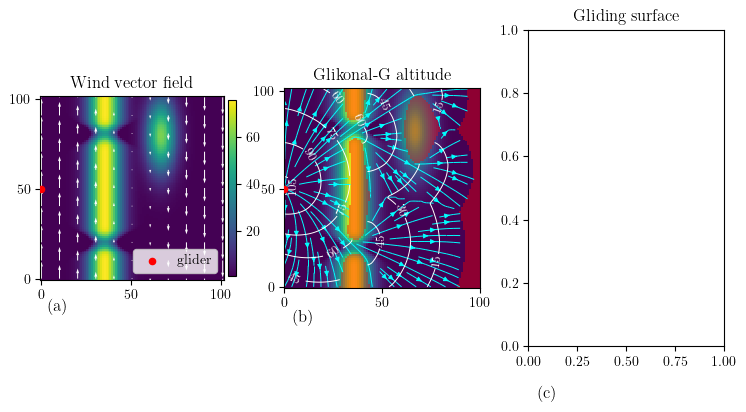

In [16]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 10}

matplotlib.rc('font', **font)
plt.rcParams.update({
    "text.usetex": True})

fig,axes=plt.subplots(1,3,figsize=(7.4,3.6))

fig.tight_layout(pad=0.6)


ax=axes[0]
X,Y=np.meshgrid(np.linspace(0,hx*W,W),np.linspace(0,hy*H,H))
U=np.moveaxis(wind_field[...,-1,1],0,1)
V=np.moveaxis(wind_field[...,-1,0],0,1)
xx,yy=np.meshgrid(np.linspace(0,hx*W,W),np.linspace(0,hy*H,H),indexing='ij')
pc=ax.pcolormesh(X,Y,elevation,cmap='viridis',shading='nearest')
fig.colorbar(pc,ax=ax,fraction=0.045, pad=0.02)
Nx=10
Ny=10

q = ax.quiver(xx[::Nx,::Ny], yy[::Nx,::Ny], U[::Nx,::Ny], V[::Nx,::Ny],color='white')
#ax.quiverkey(q, X=0.3, Y=1.1, U=10,label='.')
ax.set_aspect('equal')
ax.set_xticks([0,50,100])
ax.set_yticks([0,50,100])
ax.set_title('Wind vector field')
ax.text(0.1, -0.15, "(a)", ha='center', va='center', transform=ax.transAxes, fontsize=12)
ax.scatter([init_pos[1]*hx],[init_pos[0]*hy],color='r',label='glider',zorder=10000,s=20)
ax.legend(loc='lower right')
ax=axes[1]

X,Y=np.meshgrid(np.linspace(0,hx*W,W),np.linspace(0,hy*H,H))
pc2=ax.pcolormesh(X,Y,elevation,cmap='viridis',shading='nearest')
#pc2=ax.pcolormesh(X,Y,grid>0,cmap='binary',shading='nearest',alpha=0.1)
ax.streamplot(X,Y,grid_chars[:,:,1],grid_chars[:,:,0],density=0.94,color='aqua',linewidth=0.7,arrowsize=0.7)

CS=ax.contour(X,Y,grid,colors='white',label='aircraft',linewidths=0.7)
ax.scatter([init_pos[1]*hx],[init_pos[0]*hy],color='r',label='glider',zorder=10000,s=20)
#fig.colorbar(pc,ax=ax,fraction=0.044, pad=0.02)

grid2[grid2==-np.inf]=0
grid2[grid2>0]=np.inf
grid2[0,0]=1

colors = [(1-c,0,0,1) for c in np.linspace(0,1,100)]# Create the colormap
cmap_name = 'red_to_black'
n_bins = 100  # Number of bins (discrete color levels)
cmap_red = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
pc2=ax.pcolormesh(X,Y,grid2,cmap=cmap_red,shading='nearest',alpha=0.4)
ax.clabel(CS, fontsize=9, inline=True)
ax.set_aspect('equal')
ax.set_xticks([0,50,100])
ax.set_yticks([0,50,100])
ax.set_xlim([0,100])
ax.set_title('Glikonal-G altitude')
ax.text(0.1, -0.15, "(b)", ha='center', va='center', transform=ax.transAxes, fontsize=12)
ax=axes[2]
ax.set_title("Gliding surface")
ax.text(0.1, -0.15, "(c)", ha='center', va='center', transform=ax.transAxes, fontsize=12)
#axes[2].remove()
plt.savefig("pics/glikonal_grrp_mountauin_range.pdf", bbox_inches='tight', dpi=600)